### Heart Disease Prediction Application

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier, plot_importance

c:\Users\Ayush\Desktop\Heart Disease Pridiction\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#####  Data Loading & Preprocessing

In [2]:
def load_data(path):
    df = pd.read_csv(path)

    # Remove junk cols
    for c in ['id', 'dataset']:
        if c in df.columns:
            df.drop(c, axis=1, inplace=True)

    # Fill numeric missing with mean
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    imputer = SimpleImputer(strategy='mean')
    df[num_cols] = imputer.fit_transform(df[num_cols])

    # Map booleans / categories to numbers
    if 'sex' in df.columns:
        df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})
    if 'fbs' in df.columns:
        df['fbs'] = df['fbs'].map({True: 1, False: 0})
    if 'exang' in df.columns:
        df['exang'] = df['exang'].map({True: 1, False: 0})

    # One-hot some categorical features 
    for cat in ['cp', 'thal', 'slope', 'restecg']:
        if cat in df.columns:
            df = pd.get_dummies(df, columns=[cat], drop_first=True)

    # Convert 'num' into a binary target
    if 'num' in df.columns:
        df['Heart Disease'] = (df['num'] > 0).astype(int)
        df.drop('num', axis=1, inplace=True)

    return df


##### EDA

In [3]:
def run_eda(df):
    """Quick visual exploration of the dataset."""
    # Class balance
    sns.countplot(x='Heart Disease', data=df)
    plt.title('Heart Disease vs No Disease')
    plt.show()

    # Age distribution
    plt.hist(df['age'], bins=20, color='skyblue', edgecolor='black')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.title('Age Distribution')
    plt.show()

    # Breakdown by sex
    if 'sex' in df.columns:
        sns.countplot(x='sex', hue='Heart Disease', data=df)
        plt.title('Sex and Heart Disease')
        plt.show()

    # Fasting blood sugar
    if 'fbs' in df.columns:
        sns.countplot(x='fbs', hue='Heart Disease', data=df)
        plt.title('Fasting Blood Sugar vs Heart Disease')
        plt.show()

    # Exercise induced angina
    if 'exang' in df.columns:
        sns.countplot(x='exang', hue='Heart Disease', data=df)
        plt.title('Exercise Induced Angina vs Heart Disease')
        plt.show()

    # Cholesterol
    if 'chol' in df.columns:
        sns.boxplot(x='Heart Disease', y='chol', data=df)
        plt.title('Cholesterol Levels by Outcome')
        plt.show()

    # Resting BP
    if 'trestbps' in df.columns:
        sns.boxplot(x='Heart Disease', y='trestbps', data=df)
        plt.title('Resting BP by Outcome')
        plt.show()

    # Max heart rate
    if 'thalch' in df.columns:
        sns.boxplot(x='Heart Disease', y='thalch', data=df)
        plt.title('Max Heart Rate by Outcome')
        plt.show()

    # Correlation heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', annot=False)
    plt.title('Feature Correlation Heatmap')
    plt.show()

##### TRAIN and TUNE MODEL

In [4]:
def train_xgb(X_train, y_train):
    """Train XGBoost with simple hyperparameter tuning."""
    xgb = XGBClassifier(eval_metric='logloss', random_state=42)

    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 1.0]
    }

    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring='accuracy',
        cv=3,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)
    print("Best parameters:", grid_search.best_params_)
    return grid_search.best_estimator_

##### EVALUATE MODEL

In [5]:
def evaluate(model, X_test, y_test, feature_names):
    preds = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, preds))
    print("\nConfusion matrix:\n", confusion_matrix(y_test, preds))
    print("\nClassification report:\n", classification_report(y_test, preds))

    # Feature importance
    plot_importance(model, max_num_features=10)
    plt.show()

    # SHAP values
    explainer = shap.Explainer(model, pd.DataFrame(X_test, columns=feature_names))
    shap_values = explainer(pd.DataFrame(X_test, columns=feature_names))
    shap.summary_plot(shap_values, pd.DataFrame(X_test, columns=feature_names))

##### SAVE MODEL FOR DEPLOYMENT

In [6]:
def save_artifacts(model, scaler, feature_names):
    joblib.dump(model, 'xgb_model.pkl')
    joblib.dump(scaler, 'scaler.pkl')
    joblib.dump(list(feature_names), 'feature_names.pkl')
    print("Artifacts saved: model, scaler, feature names.")

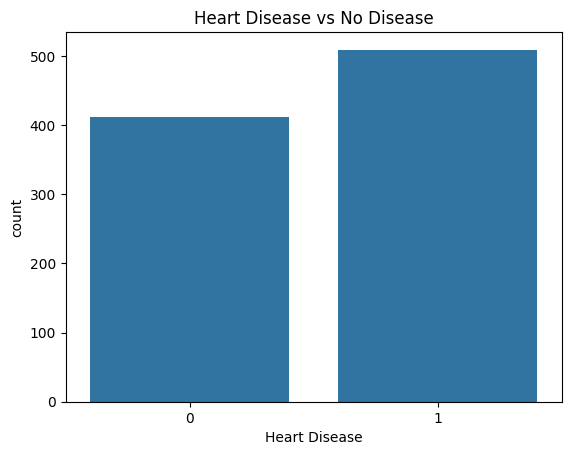

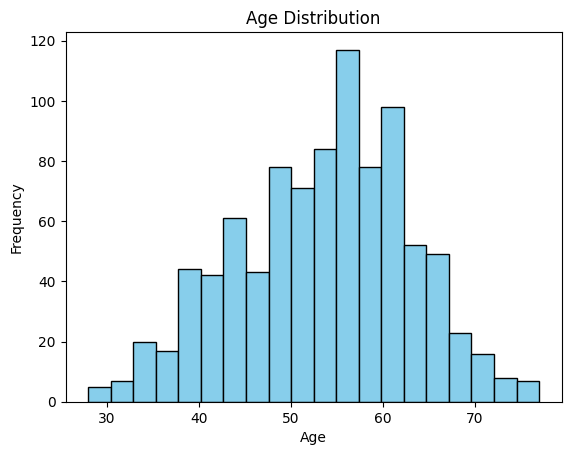

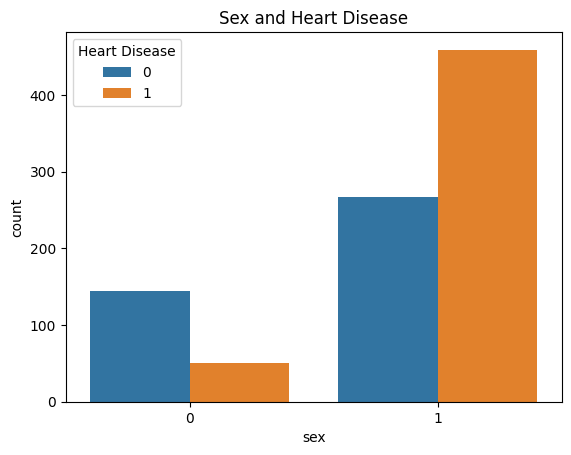

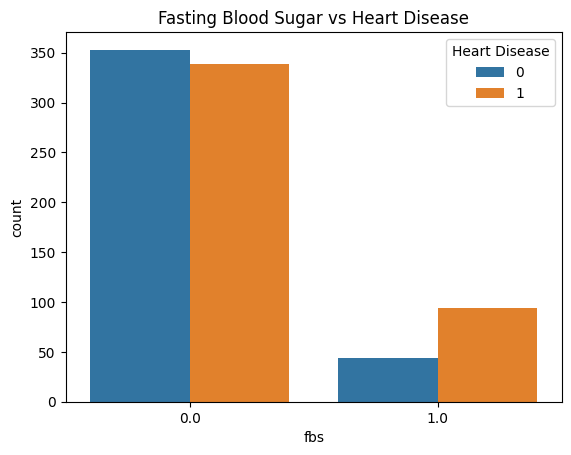

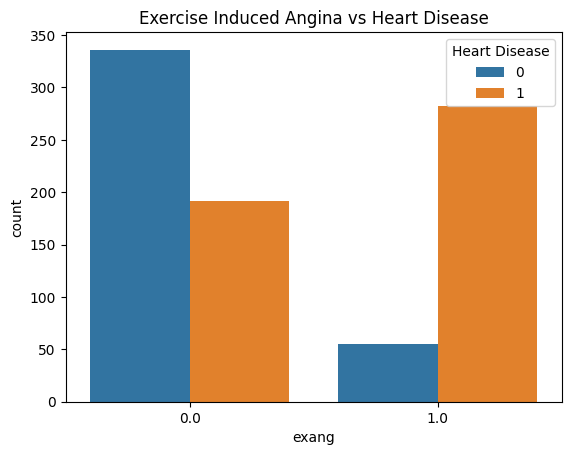

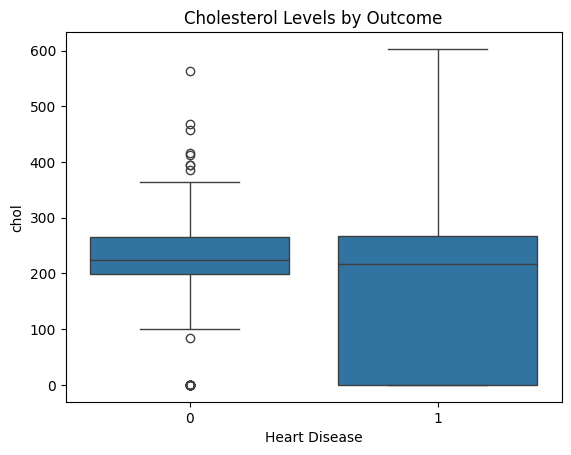

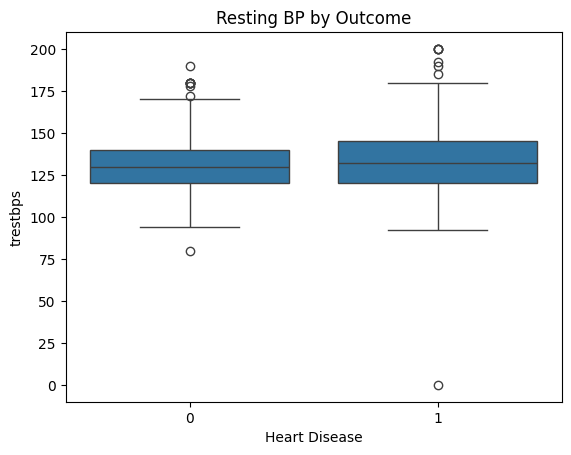

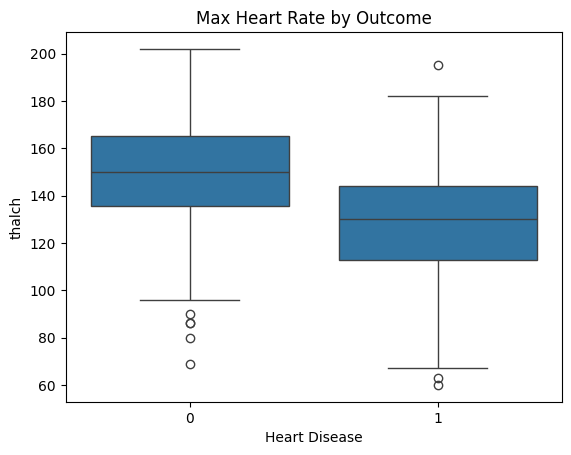

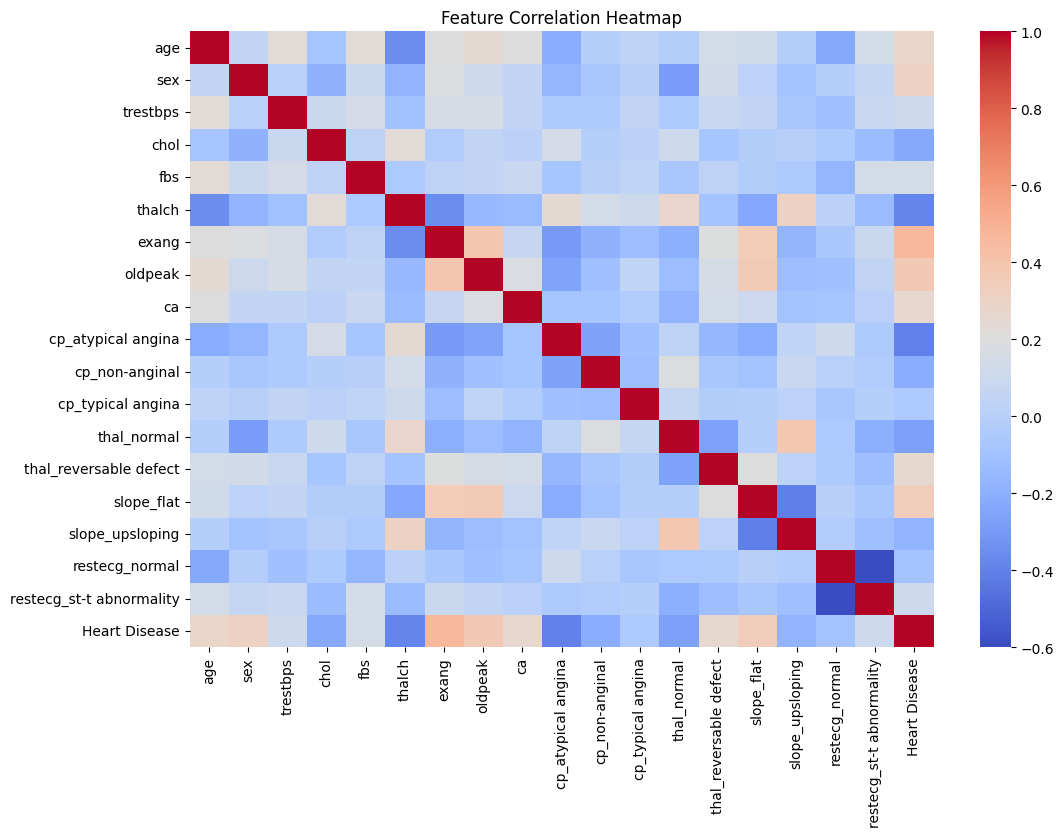

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Accuracy: 0.8586956521739131

Confusion matrix:
 [[65 10]
 [16 93]]

Classification report:
               precision    recall  f1-score   support

           0       0.80      0.87      0.83        75
           1       0.90      0.85      0.88       109

    accuracy                           0.86       184
   macro avg       0.85      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



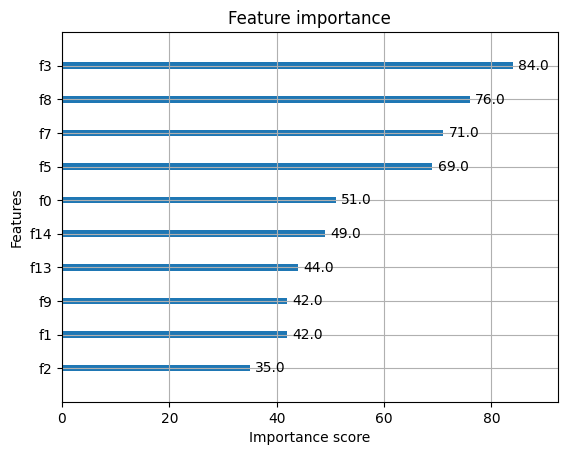

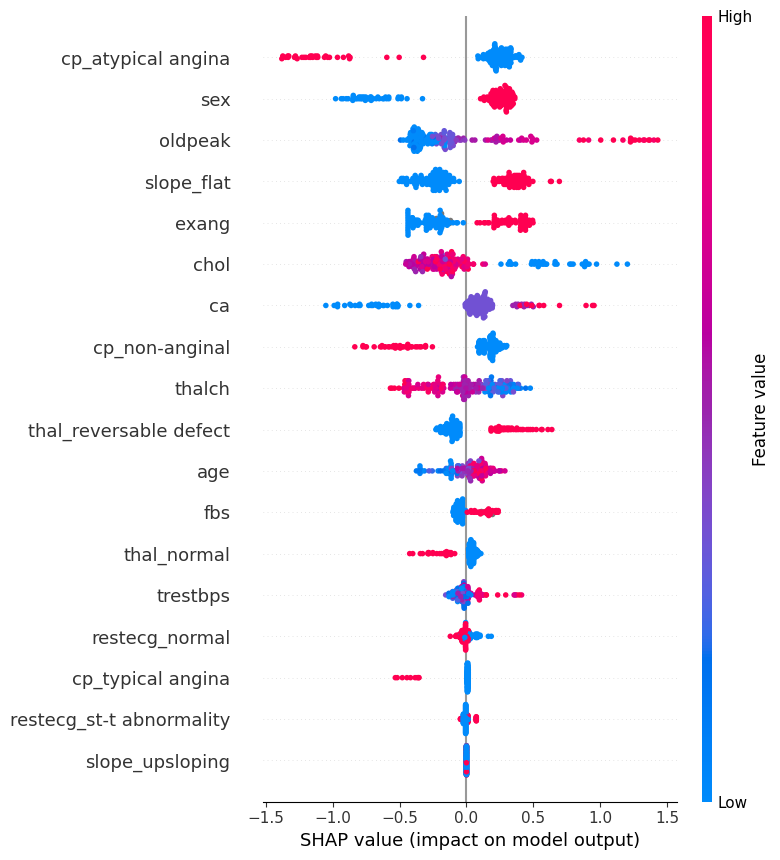

Artifacts saved: model, scaler, feature names.


In [7]:
if __name__ == '__main__':
    # Load and inspect data
    data = load_data('heart_disease_uci.csv')
    run_eda(data)

    X = data.drop(columns='Heart Disease')
    y = data['Heart Disease']
    features = X.columns

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train model
    best_model = train_xgb(X_train_scaled, y_train)

    # Evaluate model
    evaluate(best_model, X_test_scaled, y_test, features)

    # Save artifacts
    save_artifacts(best_model, scaler, features)